Task 1 

In [42]:
# import 
from IPython.display import HTML
import numpy as np
import urllib.request
import bs4 #this is beautiful soup
import time
import operator
import socket
import re # regular expressions
from bs4 import BeautifulSoup
import requests
from pandas import Series
import pandas as pd
from pandas import DataFrame
import requests
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
sns.set_context("talk")
sns.set_style("white")

In [43]:
# Extract all movie URLs
def get_movie_urls(main_page_url):
    response = requests.get(main_page_url)
    # HTML
    soup = BeautifulSoup(response.content, 'html.parser')
    # Extract relative path of movie
    movie_urls = [x.div.a.get('href') for x in soup.find_all("div", class_="card style_1")] 
    # Build the complete URL, appending language parameters
    base_url = "https://www.themoviedb.org"
    language_param = "?language=en-US"
    return [base_url + url + language_param for url in movie_urls]

In [44]:
# Extract movie details
def get_movie_details(movie_url):
    response = requests.get(movie_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract Title
    title = soup.find('h2').text.strip() if soup.find('h2') else "N/A"
    
    # Extract Year
    year = soup.find('span', class_='release_date').text.strip().replace('(', '').replace(')', '') if soup.find('span', class_='release_date') else "N/A"
    
    # Extract Certification_tag
    certification_tag = soup.find('span', class_='certification')
    certification = certification_tag.text.strip() if certification_tag else "N/A"
    
    # Extract User Score
    user_score = soup.find('div', class_='user_score_chart').get('data-percent') if soup.find('div', class_='user_score_chart') else "N/A"
   
    # Extract Description
    description = soup.find('div', class_='overview').p.text.strip() if soup.find('div', class_='overview') else "N/A"

    # Extract Director and Screenplay (crew information)
    crew_section = soup.find('ol', class_='people no_image')
    director, Screenplay = [], []
    
    if crew_section:
        for crew in crew_section.find_all('li'):
            name = crew.find('a').text.strip() if crew.find('a') else "N/A"
            job = crew.find('p', class_='character').text.strip() if crew.find('p', class_='character') else "N/A"

            if "Director" in job:
                director.append(name)
            if "Screenplay" in job:
                Screenplay.append(name)
                
    # Extract Movie Type (Genres)
    genres = [genre.text.replace('\n', '').replace('\xa0', ' ').strip() for genre in soup.find_all('span', class_='genres')] if soup.find_all('span', class_='genres') else []

    # Extract Movie Runtime
    runtime_tag = soup.find('span', class_='runtime')
    runtime = runtime_tag.text.strip() if runtime_tag else "N/A"
    # Extract Budget and Revenue
    facts_section = soup.find('section', class_='facts left_column')

    budget = revenue = "N/A" 
    if facts_section:
        p_tags = facts_section.find_all('p')
        for p_tag in p_tags:
            label = p_tag.find('strong').text.strip() if p_tag.find('strong') else ""

            # Get the full text content of p_tag
            text_value = p_tag.text.strip()   
            if 'Budget' in label:
                budget = text_value.split()[-1]
            elif 'Revenue' in label:
                revenue = text_value.split()[-1]
                
    # Extract Movie Status and Language
    status = language = "N/A"
    if facts_section:
        for p_tag in p_tags:
            label = p_tag.find('strong').text.strip() if p_tag.find('strong') else ""
            text_value = p_tag.text.strip()
            if 'Status' in label:
                status = text_value.replace('Status', '').strip()
            elif 'Original Language' in label:
                language = text_value.replace('Original Language', '').strip()      
    
    # Extract Key words
    keywords_section = soup.find('section', class_='keywords')
    keywords = [keyword.text.strip() for keyword in keywords_section.find_all('a', class_='rounded')] if keywords_section else []
    highlighted_keywords = [keyword.text.strip() for keyword in keywords_section.find_all('a', class_='!border !border-tmdb-light-blue font-semibold')] if keywords_section else []

    # return movie information
    return {
        "Title": title,
        "Year": year,
        "Certification": certification,
        "Runtime": runtime,
        "User Score": user_score,
        "Description": description,
        "Director": ", ".join(director),
        "Screenplay": ", ".join(Screenplay),
        "Genres": ", ".join(genres),
        "Budget": budget,
        "Revenue": revenue,
        "Status": status,           
        "Original Language": language, 
        "Keywords": ", ".join(keywords),
        "Highlighted Keywords": ", ".join(highlighted_keywords)
    }

In [45]:
# test 
# Example URL (replace with actual URLs from your previous step)
movie_url = "https://www.themoviedb.org/movie/912649-venom-the-last-dance?language=en-US"  # Example URL
movie_details = get_movie_details(movie_url)
# Print the movie details
#for key, value in movie_details.items():
    #print(f"{key}: {value}")

Title: Venom: The Last Dance
(2024)
Year: 2024
Certification: PG-13
Runtime: 1h 49m
User Score: 64
Description: Eddie and Venom are on the run. Hunted by both of their worlds and with the net closing in, the duo are forced into a devastating decision that will bring the curtains down on Venom and Eddie's last dance.
Director: Kelly Marcel
Screenplay: Kelly Marcel
Genres: Action, Science Fiction, Adventure
Budget: $120,000,000.00
Revenue: $8,500,000.00
Status: Released
Original Language: English
Keywords: hero, anti hero, villain, alien life-form, sequel, superhero, based on comic, woman director
Highlighted Keywords: absurd, tragic


In [46]:
# Extract movie details for all pages
def crawl_all_movies(main_page_url, max_pages):
    all_movie_data = []
    
    # Loop through pages  
    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        current_page_url = f"{main_page_url}?page={page}"
        movie_urls = get_movie_urls(current_page_url)
        
        # Scrape details for each movie on the page
        for url in movie_urls:
            print(f"Scraping movie: {url}")
            movie_data = get_movie_details(url)
            all_movie_data.append(movie_data)
            
            # Optional delay to avoid overwhelming the server
            time.sleep(1)
    
    return all_movie_data

In [47]:
# save movie details to csv file
def save_to_csv(movie_data, filename):
    # Specify the fieldnames (columns) for the CSV
    fieldnames = [
        "Title", "Year", "Certification", "Release Date", "Genres", "Runtime", 
        "Budget", "Revenue", "Status", "Original Language", "Keywords", "Highlighted Keywords"
    ]
    # Open the CSV file for writing
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header row
        writer.writeheader()
        
        # Write the movie data rows
        for movie in movie_data:
            writer.writerow(movie)


In [48]:
# crawl movie data
main_page_url = "https://www.themoviedb.org/movie"
movie_data = crawl_all_movies(main_page_url, max_pages=10)

Scraping page 1...
Scraping movie: https://www.themoviedb.org/movie/912649-venom-the-last-dance?language=en-US
Scraping movie: https://www.themoviedb.org/movie/1184918-the-wild-robot?language=en-US
Scraping movie: https://www.themoviedb.org/movie/945961-alien-romulus?language=en-US
Scraping movie: https://www.themoviedb.org/movie/933260-the-substance?language=en-US
Scraping movie: https://www.themoviedb.org/movie/1034541-terrifier-3?language=en-US
Scraping movie: https://www.themoviedb.org/movie/533535-deadpool-wolverine?language=en-US
Scraping movie: https://www.themoviedb.org/movie/698687-transformers-one?language=en-US
Scraping movie: https://www.themoviedb.org/movie/1022789-inside-out-2?language=en-US
Scraping movie: https://www.themoviedb.org/movie/519182-despicable-me-4?language=en-US
Scraping movie: https://www.themoviedb.org/movie/917496-beetlejuice-beetlejuice?language=en-US
Scraping movie: https://www.themoviedb.org/movie/1029235-azrael?language=en-US
Scraping movie: https://

ConnectTimeout: HTTPSConnectionPool(host='www.themoviedb.org', port=443): Max retries exceeded with url: /movie/1226578-longlegs?language=en-US (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000022B1B166BD0>, 'Connection to www.themoviedb.org timed out. (connect timeout=None)'))

In [10]:
# save movie data
csv_filename = 'Haoyu.li_1930327.csv'  
save_to_csv(movie_data, csv_filename)
print(f"Data saved to {csv_filename}") 

NameError: name 'movie_data' is not defined

Task 2

                           Title    Year  User Score  \
0         The Wild Robot\n(2024)  (2024)          87   
1         Alien: Romulus\n(2024)  (2024)          73   
2          The Substance\n(2024)  (2024)          73   
3   Deadpool & Wolverine\n(2024)  (2024)          77   
4  Venom: The Last Dance\n(2024)  (2024)          72   

                                         Description         Director  \
0  After a shipwreck, an intelligent robot called...    Chris Sanders   
1  While scavenging the deep ends of a derelict s...     Fede Álvarez   
2  A fading celebrity decides to usea black marke...  Coralie Fargeat   
3  A listless Wade Wilson toils away in civilian ...       Shawn Levy   
4  Eddie and Venom are on the run. Hunted by both...     Kelly Marcel   

      Screenplay                              Genres           Budget  \
0  Chris Sanders  Animation, Science Fiction, Family   $78,000,000.00   
1            NaN             Science Fiction, Horror   $80,000,000.00   
2    

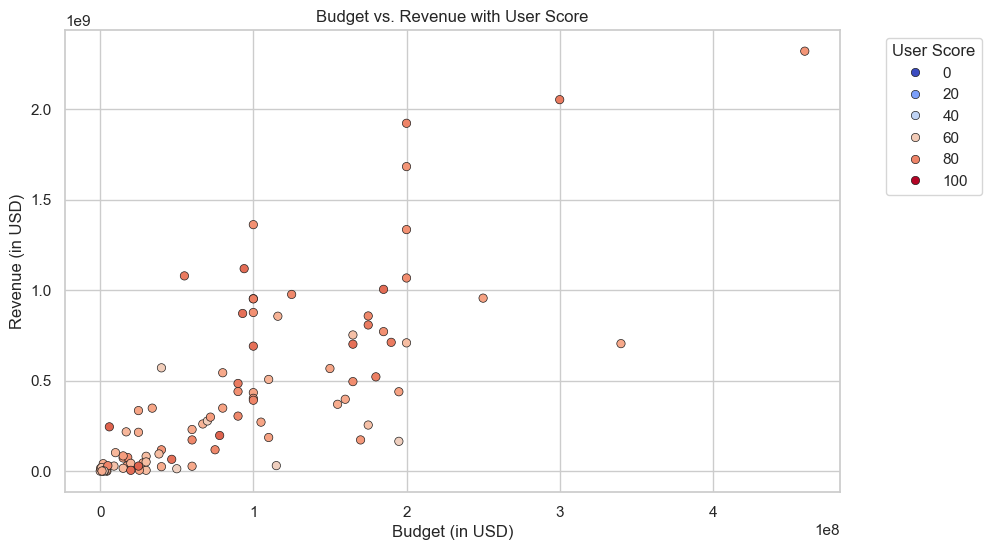

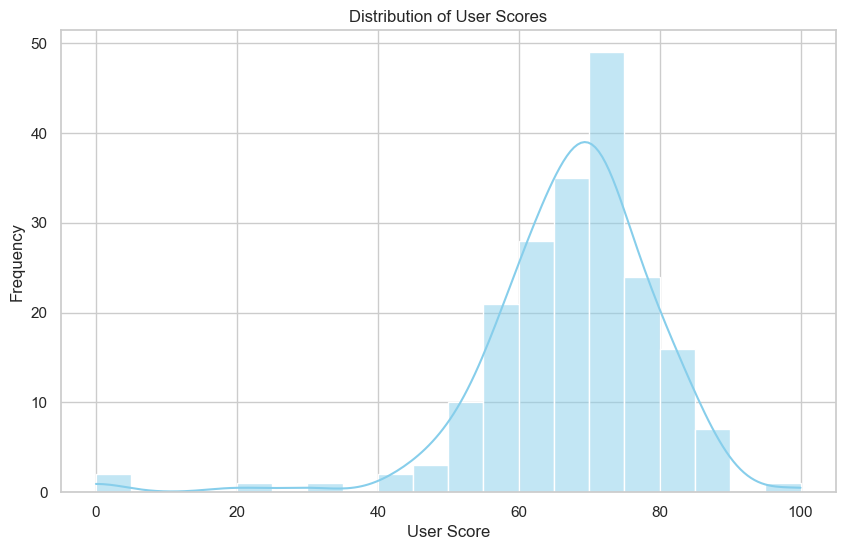

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Load the dataset
file_path = 'Haoyu.li_1930327.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Initial data inspection
print(data.head())
print(data.info())

# Data Cleaning
# Clean and convert 'Year' to integer by removing any surrounding parentheses
data['Year'] = data['Year'].str.extract('(\\d{4})').astype(int)

# Remove dollar signs and commas from 'Budget' and 'Revenue', replace '-' in 'Revenue' with NaN, and convert to floats
data['Budget'] = pd.to_numeric(data['Budget'].replace({r'\$|,': ''}, regex=True), errors='coerce')
data['Revenue'] = pd.to_numeric(data['Revenue'].replace({r'\$|,': '', '-': np.nan}, regex=True), errors='coerce')

# Display basic statistics for numeric columns
print(data.describe())

# Visualization 1: Budget vs. Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Budget', y='Revenue', hue='User Score', palette='coolwarm', edgecolor='k')
plt.title('Budget vs. Revenue with User Score')
plt.xlabel('Budget (in USD)')
plt.ylabel('Revenue (in USD)')
plt.legend(title='User Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualization 2: Distribution of User Scores
plt.figure(figsize=(10, 6))
sns.histplot(data['User Score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of User Scores')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.show()